# A case study of data wrangling using the City of London Open Street Map data

## Introduction:

The following document explores the City of London in the United Kingdom using the information available in the Open Street Map. The purpose of this analysis is to use Data Wrangling techniques to load, audit, clean and analyze a big dataset using Python and SQLite. The city of London OSM dataset is used as a case study.

<img src="other_files/mapzen_city_of_london.jpeg">


The organization of this documents is as follows:
1. Description of auditing process
2. Description of cleaning plan and process
3. Data overview
4. Additional ideas
5. Finally, the conclusion of this case study is presented.

The Python libraries used to complete this project are the following.

In [2]:
# Audit and Write CSV
import xml.etree.cElementTree as ET
import pprint
import re
from collections import defaultdict
# Audit file
import csv
import codecs
import cerberus
import sqlite3
# Analisys and graphs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 1. Description of auditing process:

The OSM file is large and contains a wide array of information from nodes and ways. The efforts of the auditing process were focused in auditing the following information with the purpose of showing how to handle different problems:

* Data types
* Node coordinates (latitude and longitude)
* Postal code format
* Street names
* Subway stations

I conducted this auditing process using the measurements of data quality as needed:

* validity 
* accuracy
* completeness 
* consistency 
* uniformity

<b><i>a) Data types</i></b>

The data types were checked for each element attribute in nodes and ways using the following code.

In [ ]:
# A function to audit the type of the attributes of an element
def audit_attribute_type(types_dictionary, attributes):
    
    for attribute in attributes:
        value = attributes[attribute]
        if value == "NULL" or value == "" or value == None:
            types_dictionary[attribute].add(type(None)) 
        elif value.startswith("{") and value.endswith("}"):
            types_dictionary[attribute].add(type([]))
        elif is_number(value):
            try:
                int(value)
                types_dictionary[attribute].add(type(1))
            except ValueError:
                float(value)
                types_dictionary[attribute].add(type(1.1))
        else:
            types_dictionary[attribute].add(type("a"))

In the following figure it can be seen that with the exception of user and value (v) attributes, all the fields have one data type. In the case of user this is not a problem as the value represents a key and all entries can be treated as strings. 

In the case of the node-tag and way-tag value attribute, types need to be treated on a case by case basis, as they represent different information. For example, some values represent postal codes, labels, hours, names, maximum speed allowed, apartment numbers, etc.

<img src="other_files/data_types.jpeg">

<b><i>b) Auditing coordinates</i></b>

To verify that the coordinates were correct, first it was checked that the data type was float value considering the information previously presented. As the latitude and longitude both have a float type, there are no coordinates in another format. 

Furthermore, I verified that the coordinates were in a reasonable range. For this a square area around London was defined. A function was built to verify that the coordinates in the OSM fall inside the area, otherwise they were stored in a dictionary for further analysis.

The code that was used is the following.

In [ ]:
# Data structure used to store wrong coordinates
coord_out_area = {}

# A function to audit coordinates
def audit_coordinates(coord_out_area, element_attributes):
    node_id = element_attributes['id']
    lati = float(element_attributes['lat'])
    longi = float(element_attributes['lon'])
    # Evaluates if the latitude and longitude fall outside the area of interest
    if not(lati > 51.4425602 and lati < 51.5785612) or not (longi > -0.21698 and longi < 0.0164795):
        coord_out_area[node_id] = (lati,longi)

For this dataset all coordinates were valid. If I had defined a smaller rectangular area maybe focusing in a particular neighborhood of the City many values would have been out of the range.

<b><i>c) Auditing postal codes</i></b>

According to the  <a href="https://en.wikipedia.org/wiki/Postcodes_in_the_United_Kingdom#Listings_and_availability">Post codes in the United Kingdom</a> article the syntax of the postal code in London can be described as follows:

<ul>
    <li>Alphanumeric</li>
    <li>Variable in length ranging from six to eight characters (including a space) long</li>
    <li>Each post code is divided into two parts separated by a single space:</li>
    <ul>
        <li><b>Outward code:</b> includes the postcode area <i>(one or two-letter)</i> and the postcode district <i>(one or two digits)</i></li>
        <li><b>Inward code:</b> includes the postcode sector <i>(one number)</i> and the postcode unit <i>(two letters)</i>.</li>
    </ul>
    <li>Additionally, the post code area <i>for London</i> corresponds to a division of the city in EC (East Central), WC (West Central), N (North), E (East), SE (South East), SW (South West), W (West), and NW (North West). 
</li>
</ul>

For example:
<img src="other_files/post_code.jpeg"> 

Therefore, I used Python's regular expressions to build the patterns finding out that some of the post codes were incomplete. Some just included the outward part (i.e. E1 or SW12), making it impossible to fix. Moreover, I was able to identify a special case pattern of recent post codes that the Royal Mail have authorized and that do not correspond 100% to the pattern previously described.

I used the following code:


In [ ]:
# Regular Expressions
# AADD DDA pattern
postal_code_type_1_re = re.compile(r'([A-Z]{1,2}[1-9]{1,2}\s[0-9][A-Z]{1,2})')
# AADA DAA pattern
postal_code_type_2_re = re.compile(r'([A-Z]{1,2}[1-9][A-Z]\s[0-9][A-Z]{1,2})')
# AADD
postal_code_type_3_re = re.compile(r'[A-Z]{1,2}[1-9]{1,2}')

# Data structure
postal_code_types = defaultdict(set)
# Counter
counter_postal_code_types = {'AADD DAA': 0, 'AADA DAA': 0, 'AADD': 0, 'unkown': 0}

# Audit potal code function
def audit_postal_code(postal_code_types, postal_code):   
    if postal_code_type_1_re.match(postal_code):
        postal_code_types['AADD DAA'].add(postal_code)
        counter_postal_code_types['AADD DAA'] += 1
    elif postal_code_type_2_re.match(postal_code):
        postal_code_types['AADA DAA'].add(postal_code)
        counter_postal_code_types['AADA DAA'] += 1
    elif postal_code_type_3_re.match(postal_code):
        postal_code_types['AADD'].add(postal_code)
        counter_postal_code_types['AADD'] += 1
    else:
        postal_code_types['unknown'].add(postal_code)
        counter_postal_code_types['unkown'] += 1

As a result, it was found that in nodes 749 postal codes were in the correct format and 104 were incomplete because they just had the outward code. Similarly, 706 postal codes in way elements were correct and 2388 were incomplete for the same reason. 

Those postal codes that only contain the outward code are not possible to be fixed because we lack information to assign and inward code.

<img src="other_files/post_codes.jpeg"> 

<b><i>d) Auditing street names</i></b>

It could be said that the street values in the OSM have been previously cleaned as almost 99% of the names appear in the correct format. Meaning that there are no abbreviations for streets, avenues, roads, etc.

However, there is a 1% in both node and way elements with street names that contain abbreviations, commas and postal codes. The following image shows the result of street names audit.

<img src="other_files/streets.jpeg"> 

The code used for street auditing is the following.

In [ ]:
# Regular expressions
street_type1_re = re.compile(r'st', re.IGNORECASE)
street_type2_re = re.compile(r',', re.IGNORECASE)
postal_code_type_1_re = re.compile(r'([A-Z]{1,2}[1-9]{1,2}\s[0-9][A-Z]{1,2})')
postal_code_type_2_re = re.compile(r'([A-Z]{1,2}[1-9][A-Z]\s[0-9][A-Z]{1,2})')
postal_code_type_3_re = re.compile(r'[A-Z]{1,2}[1-9]{1,2}')
street_types = defaultdict(set)

# Counter
type_counter = {'abbreviation': 0, 'commas': 0, 'postal_code': 0}

# Function to audit streets
def audit_street(street_types, street_name):   
    m1 = street_type1_re.search(street_name)
    m2 = street_type2_re.search(street_name)
    m3 = postal_code_type_1_re.search(street_name)
    m4 = postal_code_type_2_re.search(street_name)
    m5 = postal_code_type_3_re.search(street_name)
    if m1:
        street_type = m1.group()
        street_types[street_type].add(street_name)
        type_counter['abbreviation'] += 1
    elif m2:
        street_type = m2.group()
        street_types[street_type].add(street_name)
        type_counter['commas'] += 1
    elif m3:
        street_type = m3.group()
        street_types[street_type].add(street_name)
        type_counter['postal_code'] += 1
    elif m4:
        street_type = m4.group()
        street_types[street_type].add(street_name)
        type_counter['postal_code'] += 1
    elif m5:
        street_type = m5.group()
        street_types[street_type].add(street_name)
        type_counter['postal_code'] += 1

<b><i>e) Auditing tube stations in the City of London</i></b>

As a final exercise to verify the quality of the data, the topic of the tube stations in the City of London was chosen. 

A query to the node tags was executed where key attribute equaled station and value attribute equaled subway. As a result, 21 records were found. As the records did not detail the name of the station, another query was made to add the latitude and longitude to the dataset so they could be further compared with Google Maps.

In [3]:
db = sqlite3.connect("city_of_london.db")
c = db.cursor()
query = ''' SELECT sub.id, sub.type, sub.key, sub.value, nodes.lat, nodes.lon, nodes.user
            FROM nodes JOIN (SELECT id, type, key, value
                                    FROM node_tags
                                    WHERE key="station" and value="subway"
                                    ORDER BY key) as sub
            ON nodes.id = sub.id;'''

c.execute(query)
rows = c.fetchall()
db.close()


idk = []
typ = []
key = []
val = []
lat = []
lon = []
usr = []
for row in rows:
    idk.append(row[0])
    typ.append(row[1]) 
    key.append(row[2]) 
    val.append(row[3])
    lat.append(row[4]) 
    lon.append(row[5])
    usr.append(row[6])
print 'Results for subway stations to the City of London OSM'
pd.DataFrame({'id':idk, 'type': typ, 'key': key, 'value': val, 'latitude': lat, 'longitude': lon, 'user': usr})


Results for subway stations to the City of London OSM


,id,key,latitude,longitude,type,user,value
0,26652919,station,51.4626925,-0.1147275,regular,lcmortensen,subway
1,186194628,station,51.5587178,-0.1078741,regular,jesus_army,subway
2,1264468143,station,51.5225862,-0.1567349,regular,bjohas,subway
3,1264482797,station,51.5157049,-0.1758402,regular,Med,subway
4,1389887370,station,51.5654371,-0.1349977,regular,jesus_army,subway
5,1637578440,station,51.5133798,-0.0889552,regular,jesus_army,subway
6,1670707904,station,51.5322944,-0.1059515,regular,jesus_army,subway
7,1670707917,station,51.5394276,-0.1426923,regular,Paul The Archivist,subway
8,1721881886,station,51.526845,-0.0248534,regular,jesus_army,subway
9,1741760056,station,51.5268726,-0.0248416,regular,jesus_army,subway


In order to verify the accuracy and completeness of this subset the data was compared against Google Maps results.

From the 21 results of this query only 5 corresponded to City of London subway stations. Only one of them was missclassified because it was a train station, the rest 15 records belong to stations outside the City of London.

It is worth to point out that the dataset misses to include 5 tube stations.

Therefore, for this sort of query the data is incomplete, and there are some issues with classification.

<img src="other_files/subway.jpeg">

A way to improve the data is to revalidate data points. It is possible that the missing tube stations were classified under different tag keys.

## 2. Description of cleaning plan and process

I decided to clean the postal codes and the street names.

<b>a) Cleaning postal codes</b>

To clean the postal codes, the regular expressions in the audit process were used. A function was defined to evaluate four patterns:
* If the postal code fulfilled the <b>AADD DAA</b> or <b>AADA DAA</b> patterns, the function returned the postal code value as it was correct.
* If the postal code had this pattern <b>AADD</b>, the function returned a string saying that the <b><i>"postal code was incomplete"</i></b>. 
* For <b>any other case</b> in postal code the function returned a string saying <b><i>"not a postal code"</i></b>.

In [ ]:
# Function that updates postal code value
def update_postal_code(postal_code):      
    # Pattern AADD DAA A = letter A-Z ; D = digit 0-9
    if postal_code_type_1_re.match(postal_code):
        return postal_code
    # Pattern AADA DAA
    elif postal_code_type_2_re.match(postal_code):
        return postal_code
    # Pattern AADD
    elif postal_code_type_3_re.match(postal_code):
        return 'Postal code incomplete'
    # Any other string different than a postal code
    else:
        return 'Not a postal code'

The following query shows results for the cleaned postal codes

In [4]:
# SQL Query for Postal Codes
db = sqlite3.connect("city_of_london.db")
c = db.cursor()
query = '''select distinct type, key, value
           from way_tags
           where key = "postal_code"
           order by value desc
           limit 10;'''
c.execute(query)
rows = c.fetchall()

print "Postal codes in Way tags:"
for row in rows:
    print row
    #print row[0], ": ", row[1]

db.close()

Postal codes in Way tags:
(u'regular', u'postal_code', u'WC2V 4ET')
(u'regular', u'postal_code', u'WC2R 3JF')
(u'regular', u'postal_code', u'WC2R 2PG')
(u'regular', u'postal_code', u'WC2R 1JA')
(u'regular', u'postal_code', u'WC2R 1DA')
(u'regular', u'postal_code', u'WC2R 1AY')
(u'regular', u'postal_code', u'WC2R 1AP')
(u'regular', u'postal_code', u'WC2R 0NH')
(u'regular', u'postal_code', u'WC2R 0HS')
(u'regular', u'postal_code', u'WC2R 0ET')


<b>b) Cleaning street names</b>

To clean the streets, the regular expressions in the audit process were also used. A function to evaluate four cases was defined. 
* The <b>first case</b> substituted all abbreviations <b>St or St located at the end of the string</b> for the complete name Street. 
* The <b>second case</b> looked for <b>values that instead of a street name had an address</b>, such as: <i>"Warner Terrace, Broomfield Street"</i>. The function splitted the string into a list using the comma as a separator. It evaluated each of the items in the list created to find an expected value such as Street, Avenue or Road. If found, it returned that item in the list, in our example: <i>"Broomfield Street"</i>. If the expected value was not found it returned the original street value. 
* The <b>third case</b> removed all those street values containing a <b>postal code</b>.
* The <b>fourth case</b> just returned all the <b>correct street names</b>.

In [ ]:
# Function that updates street value    
def update_street(street_name):   
    #Case 1: Abbreviations
    if street_type1_re.search(street_name):
        street_name = re.sub( street_type1_re , ' Street',street_name)
        return  street_name
    #Case 2: Complete address
    elif street_type2_re.search(street_name):
        street_list = street_name.split(',')
        for street_item in street_list:
            for expected_item in expected:
                if expected_item in street_item:
                    street_name = street_item.strip()
        return street_name
    #case 3: Postal code
    elif postal_code_re.search(street_name):
        return ''
    #case 4: Any normal case
    else:
        return street_name

The following SQL query shows results for the cleaned street names.

In [5]:
# SQL Query for Street Name
db = sqlite3.connect("city_of_london.db")
c = db.cursor()
query = '''select distinct type, key, value
           from way_tags
           where key = "street"
           order by value
           limit 10;'''
c.execute(query)
rows = c.fetchall()

print "Street names in Way tags:"
for row in rows:
    print row
    #print row[0], ": ", row[1]

db.close()

Street names in Way tags:
(u'addr', u'street', u'')
(u'addr', u'street', u'1 Portsmouth Street')
(u'addr', u'street', u'150 Vicarage Road')
(u'addr', u'street', u'17 Old Court Place')
(u'addr', u'street', u'18-22 Damien Street')
(u'addr', u'street', u'1st Avenue')
(u'addr', u'street', u'2 Blackheath Vale')
(u'addr', u'street', u'263')
(u'addr', u'street', u'3rd Avenue')
(u'addr', u'street', u'400 Oxford Street')


## 3. Data overview

This section presents statistics about the dataset.

### 3.1 Size of the file

The following figure shows the files used in this analysis and their size in memory.
* The open street map file of the City of London is: <b>563.5 MB</b>
* The SQLite database containing the tables of the parsed OSM file is: <b>415 mb</b>

<img src="other_files/file_size.jpeg">

### 3.2 Number of unique users

Considering the nodes and ways tables, the number of <b>unique users 3,111</b> that have contributed to the OSM database for this metropolitan.

In [6]:
db = sqlite3.connect("city_of_london.db")
c = db.cursor()
query = ''' SELECT COUNT(uid) FROM
                (SELECT uid FROM nodes
                 UNION 
                 SELECT uid FROM ways) as TOTAL_USERS;'''
c.execute(query)
rows = c.fetchall()

print "Unique useres: " + str(rows[0][0])
db.close()

Unique useres: 3111


### 3.3 Number of nodes and ways

The number of node and way entries are <b>1,135,372</b> and <b>213,993</b> respectively.

In [7]:
db = sqlite3.connect("city_of_london.db")
c = db.cursor()
query = ''' SELECT COUNT(id) 
            FROM nodes;'''
c.execute(query)
rows = c.fetchall()

print "Number of nodes in the Nodes table: " + str(rows[0][0])
db.close()

Number of nodes in the Nodes table: 1135372


In [10]:
db = sqlite3.connect("city_of_london.db")
c = db.cursor()
query = ''' SELECT COUNT(id) 
            FROM ways;'''
c.execute(query)
rows = c.fetchall()

print "Number of ways in the Ways table: " + str(rows[0][0])
db.close()

Number of ways in the Ways table: 213993


### 3.4 number of chosen type of nodes, like cafes, shops etc.

A query to get the <b>top 10 amenities</b> recorded in the OSM shows that <b><i>bicycle parking, benches, restaurants, post-boxes, telephones, cafes, waste-baskets, pubs, fast food restaurants and atms dominate</i></b>. However, the distribution of these is uneven as in this top 10 bicycle parkings account to 3067 entries and atms to 589.

In [8]:
db = sqlite3.connect("city_of_london.db")
c = db.cursor()
query = ''' SELECT value, COUNT(value) as total 
            FROM node_tags
            WHERE key = "amenity"
            GROUP BY value
            ORDER BY total DESC
            LIMIT 10;'''
c.execute(query)
rows = c.fetchall()

total = []
amenity = []
for row in rows:
    amenity.append(row[0].encode('UTF-8'))
    total.append(row[1])
db.close()

Populating the interactive namespace from numpy and matplotlib


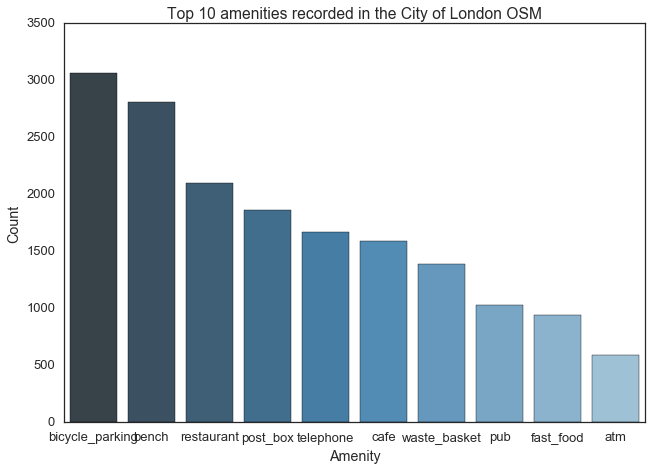

In [9]:
%pylab inline
amenity_top10 = pd.DataFrame({'amenity':amenity, 'total': total})
sns.set(style="white", context="talk")
sns.barplot('amenity','total', data = amenity_top10, palette = ("Blues_d"))
plt.title('Top 10 amenities recorded in the City of London OSM')
plt.ylabel('Count')
plt.xlabel('Amenity')
plt.show()

## 4. Additional ideas

In this section some ideas about how to improve the London Open Street Map dataset are discussed.
 
<b><i>a) Issues found in the dataset during the data wrangling process that can be improved.</i></b>
 
<ul> 
<li><b>Postal codes.</b> This data can be improved as some postal codes were found incomplete and some did not existed. A way to do this is to cross validate against the [Royal Mail](http://www.royalmail.com/find-a-postcode) database, to prevent that users enter wrong information. Another is to cross validate the postal code fields with latitude and longitude points to ensure that postal codes of South London do not end up in North London.</li>
 
<li><b>Tube stations.</b> This data is incomplete as some stations in the City of London did not appeared and this can be improved. First, data can be cross validated with the [Transport of London](https://tfl.gov.uk/) data to ensure completeness. Second, missing tube stations might be misclassified under different category tags, therefore, enforcing standard mechanisms should be placed to prevent users to wrongly classify objects in the map.</li>
 
<li><b>Streets.</b> In the street name field there were some observations containing more than one street address which should be fixed to prevent consistency issues. This can be improved by implementing field validation and regular expressions to stop the user from entering more than one street. in the final dataset.</li>
</ul> 
 
<b><i>b) Additional issues to improve data quality.</i></b>
 
<ul><li><b>Gamification</b>. <p>A gamification approach can provide tools that encourage others users through incentives to validate data and create a community that seeks to improve data quality. Consumers of Open Street Maps lack mechanisms to assess the data quality. For instance, many new users make mistakes during their learning curve to add information to the map, some bots modify the data programmatically raising issues of validity and other users just input misleading data. In this sense, the dataset does not contain information to assess the reliability of the data.</p>
 
 
<p>A way out of this problem is to use a system of performance metrics, badges and trophies to create a ladder that encourages users to ensure data quality. For instance, a user that is continuously adding data is rewarded with points and if other users validate that his data is correct he earns badges that recognize him as trustworthy. Moreover, the opposite can be true as well and the user can lose points based on incorrect or misleading information. Such information can be included in the dataset allowing to measure how reliable are the objects in the map.</p></li></ul>

## Conclusion

In this case study Python and SQLite were used to wrangle the City of London Open Street Map. As this dataset contains lots of information the data types, node coordinates, postal code format, street names and subway stations were chosen to assess the quality of the dataset.

As a result of the auditing process it can be inferred that the dataset has previously been cleaned, as the format of the street names and the format of the postal codes were 99% correct. For the resting 1% the case study suggests a way to audit and clean the street names and postal codes that are in the incorrect format. Bearing this in mind, the quality of the data in terms of validity and quality is good. 

Another, exercise was to audit the coordinates which all are in the correct format. As to how accurate are these points the exercise of auditing the subway stations showed that for a sample of points their location are correct. However, there are subway station points that remain to be added, and some that need to be reclassified. Therefore, the completeness of the dataset remains to be a data quality issue. Of course this result might or might not be a concern depending on the purpose for which the data wants to be used.  

Bearing these in mind, it can be concluded that the OSM for the City of London is valuable information, with an appropriate degree of data quality. However, data wrangling plays a key role to assess how accurate, valid, complete, consistent and uniform it is, for the purpose for which the data wants to be used.


# Appendix SQL

For this exercise the CSV files that were produced with the data wrangling coded were uploaded to a SQLite database. This is the SQL code was used to create and populate the database.

In [ ]:
sqlite3 city_of_london.db
.mode csv
.import city_of_london_nodes.csv nodes
.import city_of_london_nodes_tags.csv node_tags
.import city_of_london_ways.csv ways
.import city_of_london_ways_tags.csv way_tags
.import city_of_london_ways_nodes.csv way_nodes